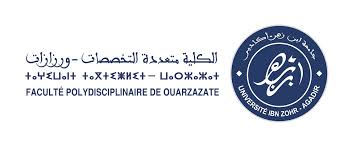

**Réaliser Par:**<br>
YOUSSEF EL WALI<br>
**Encadrer Par:**<br>
Abdelkrim EL MOUATASIM

# <span style="color: red;">Deep Learning for Gamma Telescope </span>

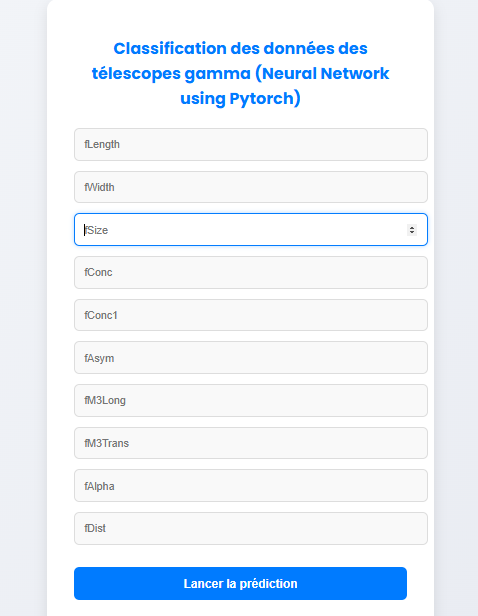

<h2 style="color:red">1-chargé les bibliothéques nécessaires</h2>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
df=pd.read_csv('telescope_data.csv')

In [ ]:
df['class']=df['class'].map({'g':0,'h':1})

In [ ]:
X = df.drop('class',axis=1)
X = X.drop('Unnamed: 0',axis=1)
y=df['class']

In [ ]:
# Sélectionner uniquement les colonnes numériques
numerical_cols = X.select_dtypes(include=['number']).columns

# Initialiser le PowerTransformer avec Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')

# Appliquer la transformation
X[numerical_cols] = pt.fit_transform(X[numerical_cols])

In [ ]:
scaler = RobustScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [ ]:
smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X,y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

**Ce code vérifie la disponibilité d'un GPU compatible CUDA et définit le périphérique de calcul sur le GPU s'il est disponible, sinon il utilise le CPU.**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Ce code définit une **réseau de neurones** en PyTorch avec deux couches cachées et fournit des méthodes pour **calculer la précision** et **entraîner le modèle** sur une époque.

In [ ]:
#build a neural network
class Net(nn.Module):
    def __init__(self, hiddenSize1, hiddenSize2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, hiddenSize1)
        self.fc2 = nn.Linear(hiddenSize1, hiddenSize2)
        self.fc3 = nn.Linear(hiddenSize2, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def getAccuracy(self, dataset):
        with torch.no_grad():
            correct = 0
            total = 0
            for x, y in dataset:
                x, y = x.to(device), y.to(device)
                output = self(x.float())
                for idx, i in enumerate(output):
                    if torch.argmax(i) == y[idx]:
                        correct += 1
                    total += 1
            return correct / total

    def trainOneEpoch(self, trainDataset, optimizer, criterion):  # Ajout de `self`
        self.train()  # Active le mode entraînement
        for data in trainDataset:
            inputs, labels = data
            inputs, labels = inputs.to(device).float(), labels.to(device)

            optimizer.zero_grad()
            outputs = self(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


# Ce code prépare les données d'entraînement et de test pour un modèle PyTorch en les transformant en DataLoader et en tenseurs PyTorch

In [ ]:
train = []
test = []
, X_test, y_train, y_test
for i in range(len(X_train)):
    train.append([X_train.iloc[i].values,y_train.iloc[i]])

for i in range(len(X_test)):
    test.append([X_test.iloc[i].values,y_test.iloc[i]])

trainDataSet = torch.utils.data.DataLoader(train, batch_size=512)
testDataSet = torch.utils.data.DataLoader(test, batch_size=512)
x_train_torch = torch.tensor(X_train.values,device=device)
y_train_torch = torch.tensor(y_train.values,device=device)
x_test_torch = torch.tensor(X_test.values,device=device)
y_test_torch = torch.tensor(y_test.values,device=device)

# Ce code effectue une validation croisée avec K-Fold sur un réseau de neurones PyTorch en testant différentes tailles de couches cachées.

In [ ]:
  # Correction de l'import
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
kfold = KFold(n_splits=10)
averageValidationAccuracy = []

# Définition des tailles de couches cachées
hiddenLayer1 = [10, 30, 50, 70, 90]
hiddenLayer2 = [10, 30, 50, 70, 90]

for i, n1 in enumerate(hiddenLayer1):
    averageValidationAccuracy.append([])
    for j, n2 in enumerate(hiddenLayer2):
        kfoldAccuracy = 0

        for train_index, test_index in kfold.split(X_train, y_train):
            x_train_fold = x_train_torch[train_index]
            y_train_fold = y_train_torch[train_index]
            x_test_fold = x_train_torch[test_index]
            y_test_fold = y_train_torch[test_index]

            train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
            test = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)
            train_loader = torch.utils.data.DataLoader(train, batch_size=512)
            test_loader = torch.utils.data.DataLoader(test, batch_size=512)

            model = Net(n1, n2)  # Vérifie que Net accepte bien n1 et n2 comme paramètres
            model.to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.01)

            for epoch in range(100):
                model.trainOneEpoch(train_loader, optimizer, criterion)  # Vérifie si criterion est requis

            kfoldAccuracy += model.getAccuracy(test_loader)

        # Calcul de la moyenne sur les 10 folds
        kfoldAccuracy /= 10
        averageValidationAccuracy[i].append(kfoldAccuracy)

        print(f"n1 = {n1}, n2 = {n2}")
        print(f"Validation Accuracy: {averageValidationAccuracy[i][j]:.4f}")


n1 = 10, n2 = 10
Validation Accuracy: 0.8616
n1 = 10, n2 = 30
Validation Accuracy: 0.8631
n1 = 10, n2 = 50
Validation Accuracy: 0.8623
n1 = 10, n2 = 70
Validation Accuracy: 0.8618
n1 = 10, n2 = 90
Validation Accuracy: 0.8657
n1 = 30, n2 = 10
Validation Accuracy: 0.8632
n1 = 30, n2 = 30
Validation Accuracy: 0.8623
n1 = 30, n2 = 50
Validation Accuracy: 0.8660
n1 = 30, n2 = 70
Validation Accuracy: 0.8623
n1 = 30, n2 = 90
Validation Accuracy: 0.8643
n1 = 50, n2 = 10
Validation Accuracy: 0.8648
n1 = 50, n2 = 30
Validation Accuracy: 0.8661
n1 = 50, n2 = 50
Validation Accuracy: 0.8644
n1 = 50, n2 = 70
Validation Accuracy: 0.8633
n1 = 50, n2 = 90
Validation Accuracy: 0.8634
n1 = 70, n2 = 10
Validation Accuracy: 0.8650
n1 = 70, n2 = 30
Validation Accuracy: 0.8610
n1 = 70, n2 = 50
Validation Accuracy: 0.8672
n1 = 70, n2 = 70
Validation Accuracy: 0.8649
n1 = 70, n2 = 90
Validation Accuracy: 0.8612
n1 = 90, n2 = 10
Validation Accuracy: 0.8667
n1 = 90, n2 = 30
Validation Accuracy: 0.8628
n1 = 90, n

# trouver la meilleure combinaison de tailles de couches cachées (hiddenLayer1, hiddenLayer2) en évacuant l'overfitting et en enregistrant le meilleur modèle.

In [ ]:
#iterate through the average validation accuracy and find the best hidden layer size
bestAccuracy = 0
bestHiddenLayer1 = 0
bestHiddenLayer2 = 0
bestAccuracy = 0
scores = []
for i,n1 in enumerate(hiddenLayer1):
    for j,n2 in enumerate(hiddenLayer2):
        model = Net(n1, n2)
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        accuracyBeforeOverfitting = 0
        for epoch in range(100):
            for inputs, labels in trainDataSet:
                model.trainOneEpoch(trainDataSet, optimizer, criterion)

            modelAccuracy = model.getAccuracy(trainDataSet)
            if(modelAccuracy- averageValidationAccuracy[i][j] > 0.05):
                break

            accuracyBeforeOverfitting = modelAccuracy
            #save the model
            if modelAccuracy > bestAccuracy:
                bestAccuracy = modelAccuracy
                torch.save(model, "model.pt")
                bestHiddenLayer1 = n1
                bestHiddenLayer2 = n2
        scores.append(accuracyBeforeOverfitting)

# Obtenir les prédictions du modèle et les étiquettes réelles pour une évaluation des performances.

In [ ]:
y_pred = []
y_actual = []
#load the model
bestModel = torch.load("model.pt")
bestModel.to("cpu")
with torch.no_grad():
    for input,labels in testDataSet:
        outputs = bestModel(input.float())
        #get the predicted class
        for i in outputs:
            y_pred.append(torch.argmax(i))
        #get the actual class
        for i in labels:
            y_actual.append(i)

<ipython-input-14-57859d656bba>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bestModel = torch.load("model.pt")


In [ ]:
print(bestHiddenLayer1,bestHiddenLayer2)

90 10


# Ce code génère un rapport de classification pour évaluer la performance du modèle sur les données de test.

In [ ]:
print(classification_report(y_actual,y_pred, target_names=['g','h']))

              precision    recall  f1-score   support

           g       0.85      0.86      0.85      2498
           h       0.86      0.84      0.85      2435

    accuracy                           0.85      4933
   macro avg       0.85      0.85      0.85      4933
weighted avg       0.85      0.85      0.85      4933



# Visualiser la matrice de confusion pour observer la distribution des prédictions du modèle par rapport aux vraies étiquettes.

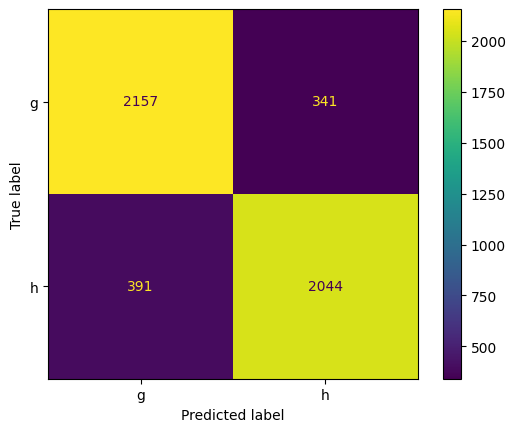

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_actual,y_pred),display_labels=['g','h']).plot()
plt.show()